# Neo4j in Python

Kaj potrebujemo (SUPB):
- Neo4j (najenostavneje `dbms.security.auth_enabled=false`)

Kaj potrebujemo (Python, `pip install ...`)
- py2neo 
- ipython-cypher
- networkx


# ipython-cypher

`ipython-cypher` ponuja direktivi `%%cypher` in `%cypher` za uporabo povpreševalnega jezika Cypher v delovnih zvezkih. 
`%cypher` je namenjen za enovrstične, `%%cypher` pa za večvrstične poizvedbe. Uporabljamo lahko ***izključno*** v delovnih zvezkih!


In [11]:
%load_ext cypher

ModuleNotFoundError: No module named 'cypher'

## Izpis vseh številk (ID) vozlišč, njihovih oznak in lastnosti.

In [75]:
%%cypher 
MATCH (n) RETURN labels(n), ID(n), n

12 rows affected.


[[['Person'], 18, {'age': 20, 'name': 'Drew'}],
 [['Person'], 19, {'age': 24, 'name': 'Nicole'}],
 [['Drink'], 20, {'calories': 0, 'name': 'Coke Zero'}],
 [['Manufacturer'], 21, {'name': 'Coca Cola'}],
 [['Manufacturer'], 22, {'name': 'Pepsi'}],
 [['Drink'], 23, {'calories': 9000, 'name': 'Mountain Dew'}],
 [['Drink'], 24, {'calories': 0, 'name': 'Coke Zero'}],
 [['Person'], 25, {'age': 20, 'name': 'Drew'}],
 [['Manufacturer'], 26, {'name': 'Pepsi'}],
 [['Person'], 27, {'age': 24, 'name': 'Nicole'}],
 [['Manufacturer'], 28, {'name': 'Coca Cola'}],
 [['Drink'], 29, {'calories': 9000, 'name': 'Mountain Dew'}]]

## py2neo: povezava na Neo4j z razredom `Graph`


In [33]:
from py2neo import Graph

graph = Graph() # Ob nastavitvi dbms.security.auth_enabled=false, sicer je potrebna avtentikacija 
                # v obliko povezovalnega niza

In [42]:
graph.delete_all()

## Vozlišča

Kreiranje vozlišč z uporabo razreda `Node`. Prvi argument je oznaka (labela, tip) vozlišča. Ostali argumenti so poljubne lastnosti (properties) vozlišča v obliki parov `ključ = vrednost`.

In [65]:
from py2neo import Node

# Kreiranje vozlišč
nicole = Node("Person", name="Nicole", age=24)
drew = Node("Person", name="Drew", age=20)

mtdew = Node("Drink", name="Mountain Dew", calories=9000)
cokezero = Node("Drink", name="Coke Zero", calories=0)

coke = Node("Manufacturer", name="Coca Cola")
pepsi = Node("Manufacturer", name="Pepsi")

# Kreiranje grafa
graph.create(nicole | drew | mtdew | cokezero | coke | pepsi)


In [69]:
pepsi

(pepsi:Manufacturer {name:"Pepsi"})

## Povezave (razmerja)

Kreiranje povezav med vozlišči z uporabo razreda `Relationship`.

In [57]:
from py2neo import Relationship

graph.create(Relationship(nicole, "LIKES", cokezero))
graph.create(Relationship(nicole, "LIKES", mtdew))
graph.create(Relationship(drew, "LIKES", mtdew))
graph.create(Relationship(coke, "MAKES", cokezero))
graph.create(Relationship(pepsi, "MAKES", mtdew))


In [56]:
%%cypher
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name, drink.name, drink.calories

3 rows affected.


[['Drew', 'Mountain Dew', 9000],
 ['Nicole', 'Mountain Dew', 9000],
 ['Nicole', 'Coke Zero', 0]]

## py2neo in Cypher

Izvajanje Cypher poizvedb z uporabo metode `Graph.cypher.execute`.

In [59]:
query = """
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name AS name, drink.name AS drink
"""

data = graph.run(query)

for d in data:
    print(d)

('name': 'Drew', 'drink': 'Mountain Dew')
('name': 'Nicole', 'drink': 'Mountain Dew')
('name': 'Nicole', 'drink': 'Coke Zero')


## py2neo - parametrizirane  Cypher poizvedbe


Ob klicu metode  `Graph.cypher.execute` lahko podamo parametre v parov ključ=vrednost. Parametri v Cypher poizvedbi so poimenovani znotraj zavitih oklepajev.

In [60]:
query = """
MATCH (p:Person)-[:LIKES]->(drink:Drink)
WHERE p.name = {name}
RETURN p.name AS name, AVG(drink.calories) AS avg_calories
"""

data = graph.run(query, name="Nicole") # Parameter {name} dobi vrednost "Nicole" 

for d in data:
    print(d)

('name': 'Nicole', 'avg_calories': 4500.0)


## NetworkX 

Modul za delo z grafi (omrežji). Omogoča enostaven izris.

3 rows affected.


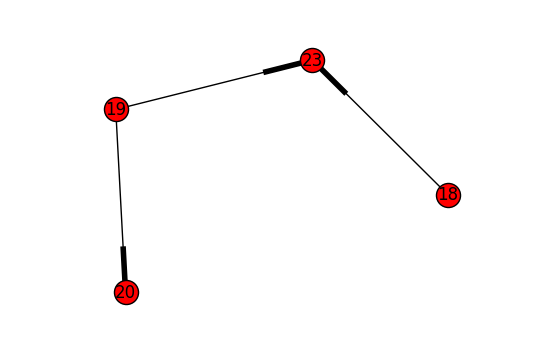

In [72]:
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
results = %cypher MATCH p = (:Person)-[:LIKES]->(:Drink) RETURN p

g = results.get_graph()

nx.draw_networkx(g, arrows=True); _=plt.axis('off')

In [73]:
g.nodes(data=True)

[('19', {'age': 24, 'labels': ['Person'], 'name': 'Nicole'}),
 ('20', {'calories': 0, 'labels': ['Drink'], 'name': 'Coke Zero'}),
 ('23', {'calories': 9000, 'labels': ['Drink'], 'name': 'Mountain Dew'}),
 ('18', {'age': 20, 'labels': ['Person'], 'name': 'Drew'})]

In [74]:
nx.degree(g)

{'18': 1, '19': 2, '20': 1, '23': 2}